This notebook aims to clarify the difference between the L22 and Du et al., see \section{Comparison with L22's results} in the Appendix B.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import bilby
from bilby.core.prior import Uniform
from bilby.hyper.likelihood import HyperparameterLikelihood
from bilby.core.utils import check_directory_exists_and_if_not_mkdir
from bilby.core.sampler import run_sampler


In [2]:
input_txt = "L22_GRB_LIV_lower_limits_data.txt"   
n_samples = 1000                             
output_dir = "."          
run_bilby = True      
                    
# bilby sampler kwargs
bilby_kwargs = dict(
    sampler="dynesty",
    nlive=1000,
    use_ratio=False,
    verbose=True,
    clean=True,
)

In [6]:
df = pd.read_csv(input_txt, delim_whitespace=True, header=0)
grb_col = [col for col in df.columns if df[col].astype(str).str.contains('GRB').any()][0]
numeric_cols = [col for col in df.columns if col != grb_col and df[col].apply(pd.to_numeric, errors='coerce').notna().all()]
lin_col, quad_col = numeric_cols[0], numeric_cols[1]

def parse_scientific(tok):
    if isinstance(tok, str):
        return pd.to_numeric(tok.replace('×', 'e').replace('X', 'e').replace(' ', '').replace('E+', 'e').replace('E-', 'e'), errors='coerce')
    return pd.to_numeric(tok, errors='coerce')

clean = pd.DataFrame()
clean['GRBname'] = df[grb_col].str.replace(r'\s+', '', regex=True)
clean['Eqg_linear'] = df[lin_col].apply(parse_scientific)
clean['Eqg_quad'] = df[quad_col].apply(parse_scientific)

clean = clean.dropna().reset_index(drop=True)
print(clean)


        GRBname    Eqg_linear    Eqg_quad
0    GRB210619B  5.520000e+15  17200000.0
1    GRB210610B  3.230000e+13    203000.0
2    GRB210204A  1.020000e+13    131000.0
3   GRB2101216C  1.900000e+14    338000.0
4    GRB200829A  4.280000e+14   2520000.0
5    GRB200613A  4.740000e+13    168000.0
6    GRB190114C  5.430000e+14   2220000.0
7    GRB180720B  9.540000e+14   6460000.0
8    GRB180703A  3.600000e+13    119000.0
9    GRB171010A  5.680000e+13     99600.0
10   GRB160625B  1.350000e+15   7280000.0
11   GRB160509A  1.730000e+14    521000.0
12   GRB150821A  1.010000e+13    110000.0
13   GRB150514A  3.570000e+13    130000.0
14   GRB150403A  2.180000e+13    580000.0
15   GRB150314A  3.910000e+14    285000.0
16   GRB141028A  1.530000e+14    275000.0
17   GRB140508A  1.210000e+14    477000.0
18   GRB140206A  4.570000e+14    933000.0
19   GRB131231A  2.090000e+13    191000.0
20   GRB131108A  2.100000e+14    604000.0
21   GRB130925A  8.180000e+12     61500.0
22   GRB130518A  2.550000e+14   16

/var/folders/9j/vtd4x1x94s7bn6rm0gq4__rm0000gp/T/ipykernel_4123/1093461524.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(input_txt, delim_whitespace=True, header=0)


In [11]:
grb_names = clean['GRBname'].values
linear_vals = clean['Eqg_linear'].values
quad_vals = clean['Eqg_quad'].values

In [12]:
linear_vals

array([5.52e+15, 3.23e+13, 1.02e+13, 1.90e+14, 4.28e+14, 4.74e+13,
       5.43e+14, 9.54e+14, 3.60e+13, 5.68e+13, 1.35e+15, 1.73e+14,
       1.01e+13, 3.57e+13, 2.18e+13, 3.91e+14, 1.53e+14, 1.21e+14,
       4.57e+14, 2.09e+13, 2.10e+14, 8.18e+12, 2.55e+14, 3.85e+14,
       1.25e+13, 3.46e+13, 2.34e+14, 1.09e+14, 4.01e+13, 6.17e+13,
       7.14e+13, 6.45e+14])

In [13]:
quad_vals

array([17200000.,   203000.,   131000.,   338000.,  2520000.,   168000.,
        2220000.,  6460000.,   119000.,    99600.,  7280000.,   521000.,
         110000.,   130000.,   580000.,   285000.,   275000.,   477000.,
         933000.,   191000.,   604000.,    61500.,  1640000.,  2750000.,
         297000.,   215000.,   622000.,   845000.,   197000.,   217000.,
         241000.,  1220000.])

In [14]:
# for each of 32 GRBs sample 1000 draws from delta-distribution (repeat the values)
linear_samples = np.vstack([np.repeat(v, n_samples) for v in linear_vals])
quad_samples   = np.vstack([np.repeat(v, n_samples) for v in quad_vals])

In [15]:
# compute log10 samples (avoid non-positive values)
if (linear_samples <= 0).any() or (quad_samples <= 0).any():
    raise ValueError("Found non-positive Eqg values; cannot take log10.")

log_linear = np.log10(linear_samples)
log_quad   = np.log10(quad_samples)

linear_posteriors = []
quad_posteriors = []

for i, name in enumerate(grb_names):
    df_lin = pd.DataFrame({'logEQG': log_linear[i,:]})
    df_quad= pd.DataFrame({'logEQG': log_quad[i,:]})
    linear_posteriors.append(df_lin)
    quad_posteriors.append(df_quad)


In [ ]:
# Hierarchical inference with bilby

def hyper_prior_logEQG(dataset, mu, sigma):
    x = dataset['logEQG']
    return np.exp(-0.5 * ((x - mu) ** 2) / (sigma ** 2)) / np.sqrt(2 * np.pi * sigma ** 2)

for sample in linear_posteriors:
    sample["prior"] = 1.0e-6
for sample in quad_posteriors:
    sample["prior"] = 1.0e-6

if run_bilby:
    # Linear run
    hp_likelihood_linear = HyperparameterLikelihood(
        posteriors=linear_posteriors,
        hyper_prior=hyper_prior_logEQG,
        log_evidences=10E-6,
        max_samples=5000
    )

    # Quadratic run
    hp_likelihood_quad = HyperparameterLikelihood(
        posteriors=quad_posteriors,
        hyper_prior=hyper_prior_logEQG,
        log_evidences=10E-6,
        max_samples=5000
    )

    hp_priors_linear = dict(
        mu=Uniform(0, 20, "mu", r"$\mu$"),
        sigma=Uniform(0, 10, "sigma", r"$\sigma$"),
    )
    
    hp_priors_quad = dict(
        mu=Uniform(0, 20, "mu", r"$\mu$"),
        sigma=Uniform(0, 10, "sigma", r"$\sigma$"),
    )

    outdir_linear = os.path.join(output_dir, "linear")
    outdir_quad   = os.path.join(output_dir, "quadratic")
    check_directory_exists_and_if_not_mkdir(outdir_linear)
    check_directory_exists_and_if_not_mkdir(outdir_quad)

    # print("Running bilby hierarchical inference (linear)...")
    result_linear = run_sampler(
        likelihood=hp_likelihood_linear,
        priors=hp_priors_linear,
        outdir=outdir_linear,
        label="hyperLIV_linear",
        **bilby_kwargs
    )
    result_linear.plot_corner(save=True, priors=hp_priors_linear)

    # print("Running bilby hierarchical inference (quadratic)...")
    result_quad = run_sampler(
        likelihood=hp_likelihood_quad,
        priors=hp_priors_quad,
        outdir=outdir_quad,
        label="hyperLIV_quadratic",
        **bilby_kwargs
    )
    result_quad.plot_corner(save=True, priors=hp_priors_quad)

    # print("bilby runs finished. Results in:", outdir_linear, outdir_quad)



17:44 bilby INFO    : Running for label 'hyperLIV_linear', output will be saved to 'L22_DU_difference_clarify_results/linear'


Running bilby hierarchical inference (linear)...


17:44 bilby INFO    : Analysis priors:
17:44 bilby INFO    : mu=Uniform(minimum=0, maximum=20, name='mu', latex_label='$\\mu$', unit=None, boundary=None)
17:44 bilby INFO    : sigma=Uniform(minimum=0, maximum=10, name='sigma', latex_label='$\\sigma$', unit=None, boundary=None)
17:44 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
17:44 bilby INFO    : Analysis likelihood noise evidence: 1e-05
17:44 bilby INFO    : Single likelihood evaluation took 1.884e-04 s
17:44 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 1000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args': None, 'grad_kwargs': None, 'compute_jac': False, 'enlarge': None, 'boots

1it [00:00, ?it/s]

17:45 bilby INFO    : Written checkpoint file L22_DU_difference_clarify_results/linear/hyperLIV_linear_resume.pickle
17:45 bilby INFO    : Written checkpoint file L22_DU_difference_clarify_results/linear/hyperLIV_linear_resume.pickle
17:45 bilby INFO    : Rejection sampling nested samples to obtain 2787 posterior samples
17:45 bilby INFO    : Sampling time: 0:00:54.306840
17:45 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


17:45 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
17:45 bilby INFO    : Summary of results:
nsamples: 2787
ln_noise_evidence:  0.000
ln_evidence: 401.307 +/-  0.106
ln_bayes_factor: 401.307 +/-  0.106

17:45 bilby INFO    : Running for label 'hyperLIV_quadratic', output will be saved to 'L22_DU_difference_clarify_results/quadratic'


Running bilby hierarchical inference (quadratic)...


17:45 bilby INFO    : Analysis priors:
17:45 bilby INFO    : mu=Uniform(minimum=0, maximum=20, name='mu', latex_label='$\\mu$', unit=None, boundary=None)
17:45 bilby INFO    : sigma=Uniform(minimum=0, maximum=10, name='sigma', latex_label='$\\sigma$', unit=None, boundary=None)
17:45 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
17:45 bilby INFO    : Analysis likelihood noise evidence: 1e-05
/home/dss/anaconda3/envs/py311/lib/python3.11/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
17:45 bilby INFO    : Single likelihood evaluation took 1.912e-04 s
17:45 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 1000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_p

1it [00:00, ?it/s]

/home/dss/anaconda3/envs/py311/lib/python3.11/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
17:46 bilby INFO    : Written checkpoint file L22_DU_difference_clarify_results/quadratic/hyperLIV_quadratic_resume.pickle
17:46 bilby INFO    : Written checkpoint file L22_DU_difference_clarify_results/quadratic/hyperLIV_quadratic_resume.pickle
17:46 bilby INFO    : Rejection sampling nested samples to obtain 2781 posterior samples
17:46 bilby INFO    : Sampling time: 0:00:57.749103
17:46 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
17:46 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
17:46 bil

bilby runs finished. Results in: L22_DU_difference_clarify_results/linear L22_DU_difference_clarify_results/quadratic


plot the PPD

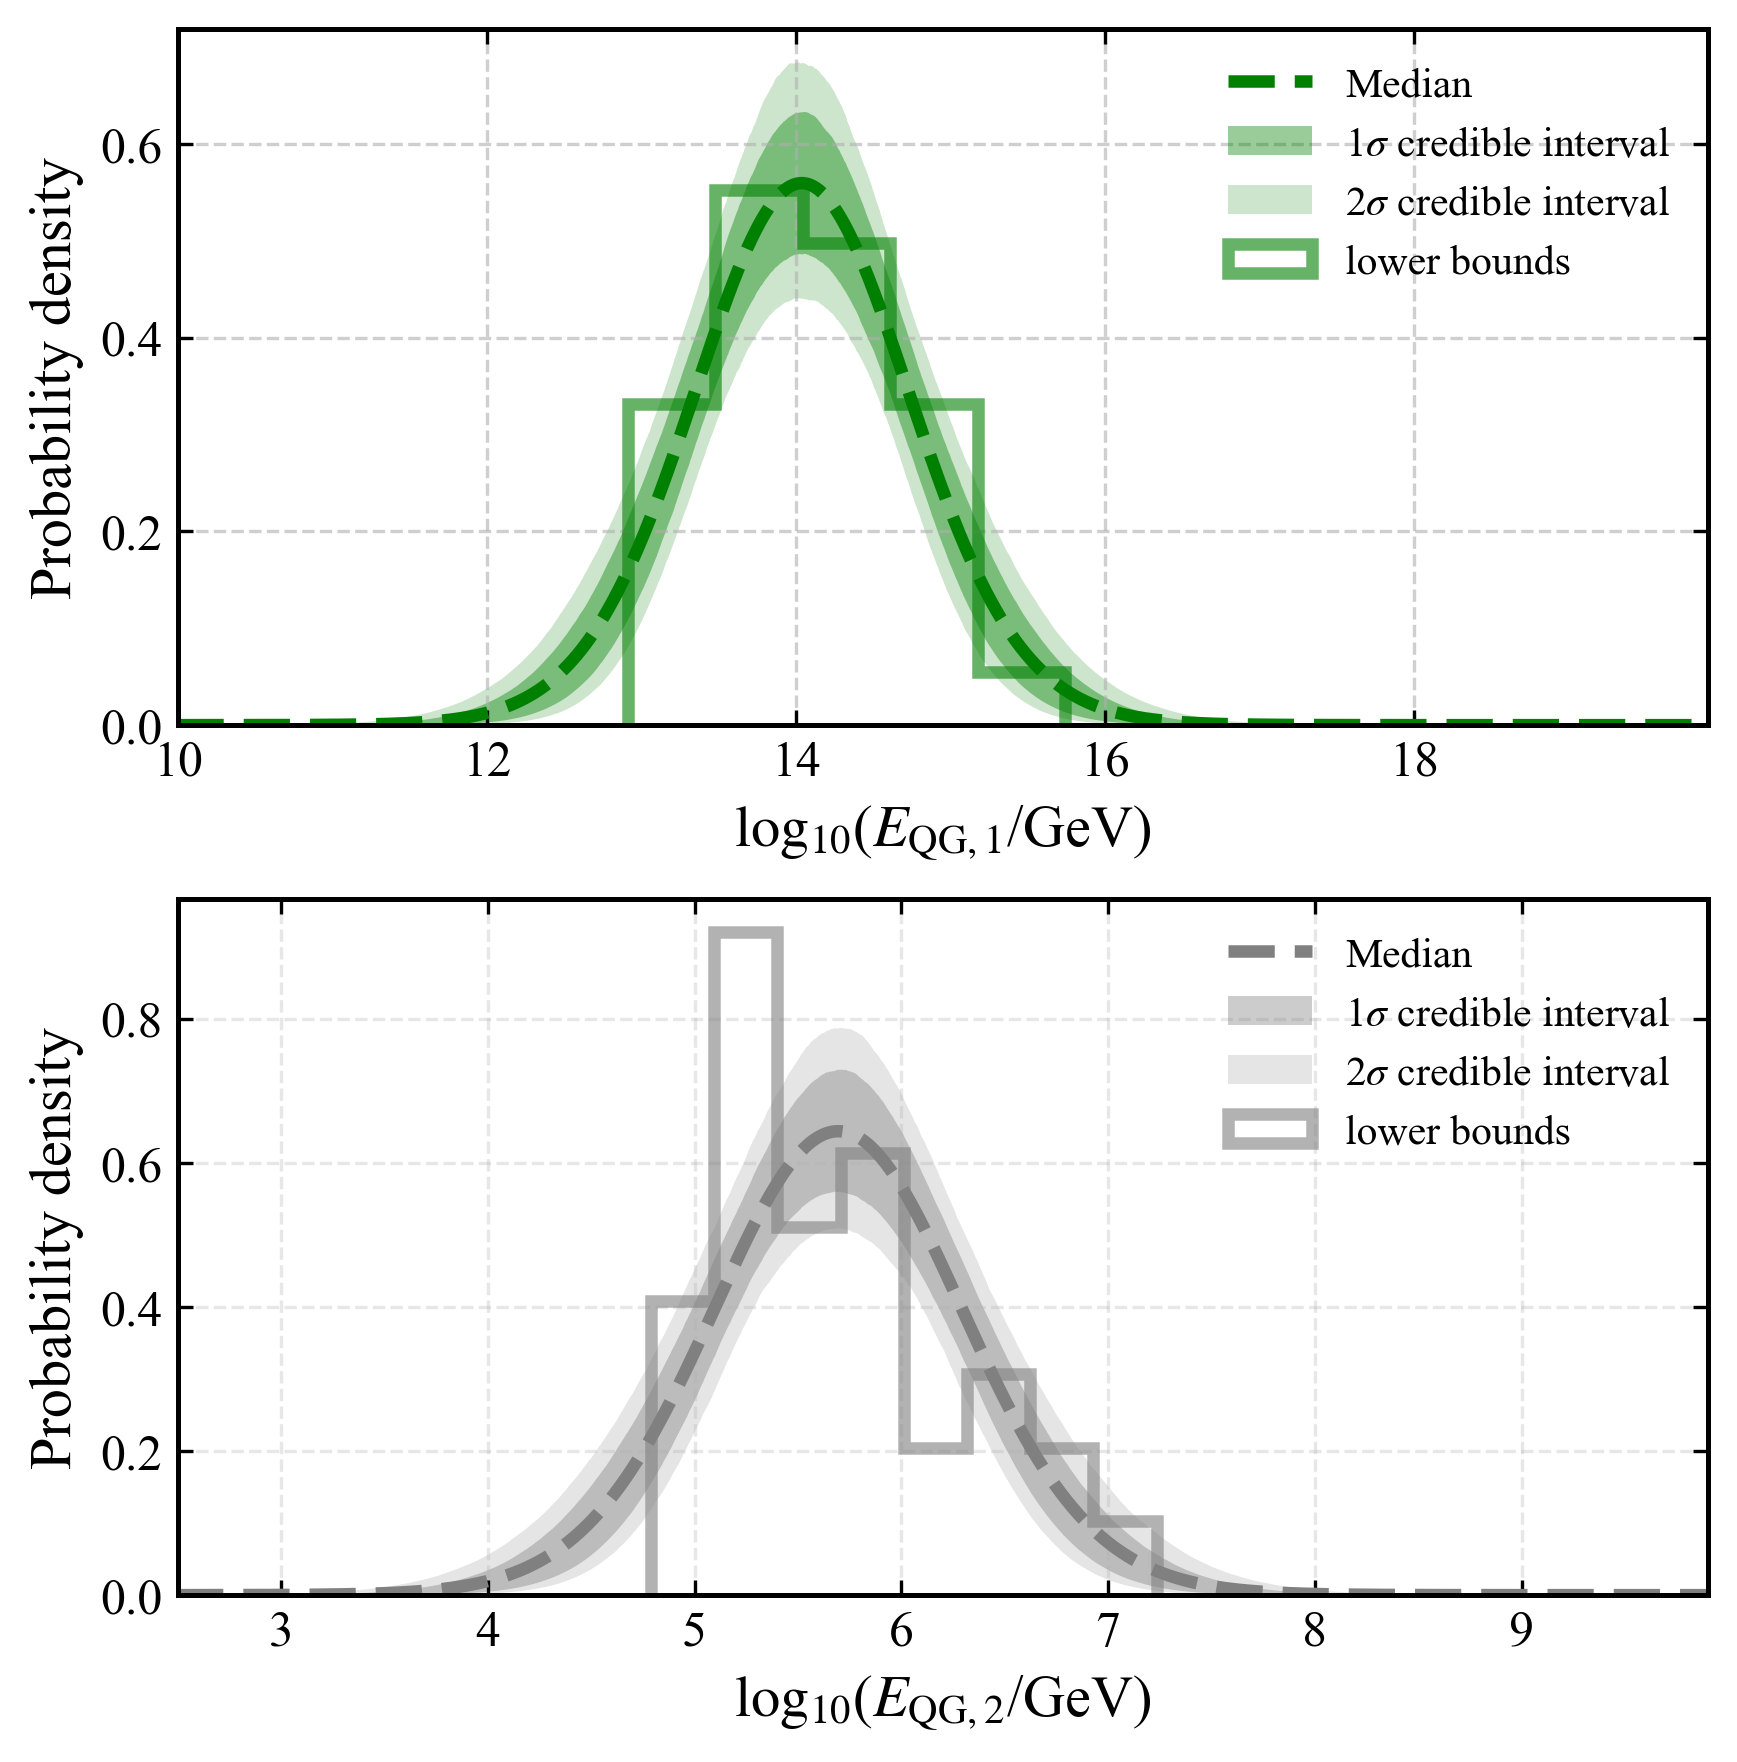

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'mathtext.fontset': 'stix',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

from matplotlib import rcParams
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

def hyper_gauss(dataset, mu, sigma):
    x = dataset
    return np.exp(-0.5 * ((x - mu) ** 2) / (sigma ** 2)) / np.sqrt(2 * np.pi * sigma ** 2)
    
def ppd_gauss(x, pos_p):
    mar = []
    row, col = pos_p.shape
    for i in range(row):
        ma = hyper_gauss(np.array(x), pos_p[i, 0], pos_p[i, 1]) 
        mar.append(ma) 
    return np.sum(np.array(mar), axis=0) / row

def errbar_gauss(x, pos_p, quantile):
    mar = []
    row, col = pos_p.shape
    for i in range(row):
        ma = hyper_gauss(np.array(x), pos_p[i, 0], pos_p[i, 1]) 
        mar.append(ma)
    return np.quantile(np.array(mar), quantile, axis=0)

quantile_1sigma = np.array([0.16, 0.84])
quantile_2sigma = np.array([0.05, 0.95])

linear_dir = '{}/linear/hyperLIV_linear_result.json'.format(output_dir)
quad_dir = '{}/quadratic/hyperLIV_quadratic_result.json'.format(output_dir)

x = np.array(np.linspace(0.01, 20.0, 5000))

result_linear = bilby.result.read_in_result(filename=linear_dir)
posterior_linear = result_linear.posterior[['mu', 'sigma']].values

ppd_linear = ppd_gauss(x, posterior_linear)
ppd_err_linear_1sigma = errbar_gauss(x, posterior_linear, quantile_1sigma)
ppd_err_linear_2sigma = errbar_gauss(x, posterior_linear, quantile_2sigma)

result_quad = bilby.result.read_in_result(filename=quad_dir)
posterior_quad = result_quad.posterior[['mu', 'sigma']].values

ppd_quad = ppd_gauss(x, posterior_quad)
ppd_err_quad_1sigma = errbar_gauss(x, posterior_quad, quantile_1sigma)
ppd_err_quad_2sigma = errbar_gauss(x, posterior_quad, quantile_2sigma)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
plt.subplots_adjust(left=0.12, right=0.97, top=0.95, bottom=0.08, hspace=0.25)

color_linear = 'green'
color_quad = 'gray'

ax1.plot(x, ppd_linear, ls='--', color=color_linear, lw=3, label='Median')
ax1.fill_between(x, ppd_err_linear_1sigma[0, :], ppd_err_linear_1sigma[1, :], 
                 alpha=0.4, facecolor=color_linear, label=r'1$\sigma$ credible interval')
ax1.fill_between(x, ppd_err_linear_2sigma[0, :], ppd_err_linear_2sigma[1, :], 
                 alpha=0.2, facecolor=color_linear, label=r'2$\sigma$ credible interval')

ax1.hist(log_linear.flatten(), density=True, bins=5, histtype='step', color=color_linear, lw=3, alpha=0.6, label='lower bounds')
ax1.set_xlim([10, 19.9])
ax1.set_ylabel("Probability density", fontname='Times New Roman', fontsize=14)
ax1.legend(loc='upper right', frameon=False, fancybox=True, shadow=False, fontsize=10, ncol=1)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlabel(r"$\text{log}_{10}$($E_{\rm QG,1}$/GeV)", fontname='Times New Roman', fontsize=14)

ax2.plot(x, ppd_quad, ls='--', color=color_quad, lw=3, label='Median')
ax2.fill_between(x, ppd_err_quad_1sigma[0, :], ppd_err_quad_1sigma[1, :], 
                 alpha=0.4, facecolor=color_quad, label=r'1$\sigma$ credible interval')
ax2.fill_between(x, ppd_err_quad_2sigma[0, :], ppd_err_quad_2sigma[1, :], 
                 alpha=0.2, facecolor=color_quad, label=r'2$\sigma$ credible interval')

ax2.hist(log_quad.flatten(), density=True, bins=8, histtype='step',  color=color_quad, lw=3, alpha=0.6, label='lower bounds')
ax2.set_xlim([2.5, 9.9])
ax2.set_xlabel(r"$\text{log}_{10}$($E_{\rm QG,2}$/GeV)", fontname='Times New Roman', fontsize=14)
ax2.set_ylabel("Probability density", fontname='Times New Roman', fontsize=14)
ax2.legend(loc='upper right', frameon=False, fancybox=True, shadow=False, fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.3)

for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

# plt.savefig("./{}/fig_ppd_EQG_L22.png".format(output_dir), dpi=300)
plt.show()